In [131]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import typing as t
import tensorflow as tf
import numpy as np
print("Version TensorFlow :", tf.__version__)
print("GPU disponible :", tf.config.list_physical_devices('GPU'))

Version TensorFlow : 2.20.0
GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


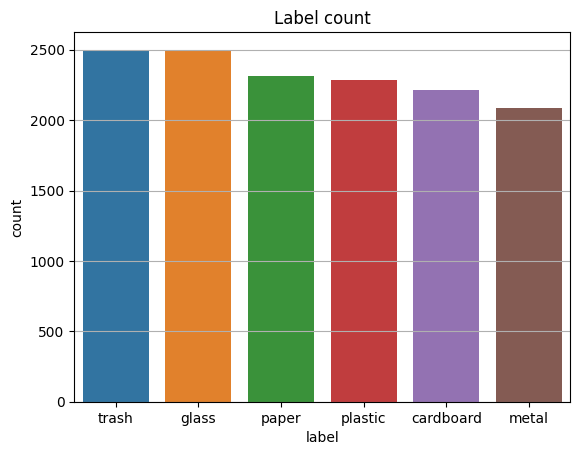

,filename,label
0,cardboard_02038.jpg,cardboard
1,cardboard_02320.jpg,cardboard
2,cardboard_01728.jpg,cardboard
3,cardboard_00093.jpg,cardboard
4,cardboard_00094.jpg,cardboard


In [132]:
metadata = pd.read_csv(Path("Garbage_Dataset_Classification/metadata.csv"))


def plot_label_distribution(
    metadata_df: pd.DataFrame,
    label_column:str="label",
    title: str = "Label count",
    y_lim:t.Optional[t.Tuple[int, int]] = None
):
    """Plot the label distribution as barplot.

    Args:
        metadata (pd.DataFrame): The metadata dataframe.
        label_column (str, optional): name of the label column.
            Defaults to "label".
        title (str, optional): Title of the figure. Defaults to "label count"
        y_lim (tuple, optional): y_lim tuple. See matplotlib docs.
            Defaults to None.
        
    """
    label_distribution = pd.DataFrame(metadata_df[label_column].value_counts()).reset_index()

    plt.title(title)
    plt.grid()
    sns.barplot(label_distribution, x=label_column, y="count", hue=label_column)
    if y_lim:
        plt.ylim(y_lim)
    plt.show()

plot_label_distribution(metadata_df=metadata)
metadata.head()

In [133]:
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
CLASSES

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [134]:
RAW_IMAGE_DIR = Path("Garbage_Dataset_Classification/images")


def compute_relative_path(
    row: pd.Series, raw_image_dir: Path = RAW_IMAGE_DIR, to_str: bool = True
):
    image_path = raw_image_dir.joinpath(row["label"], row["filename"])
    if to_str:
        # tensorflow doesn't handle Posix Path well. Use string instead.
        image_path = str(image_path)
    return image_path


metadata["filename"] = metadata.apply(compute_relative_path, axis=1)
metadata

,filename,label
0,Garbage_Dataset_Classification/images/cardboar...,cardboard
1,Garbage_Dataset_Classification/images/cardboar...,cardboard
2,Garbage_Dataset_Classification/images/cardboar...,cardboard
3,Garbage_Dataset_Classification/images/cardboar...,cardboard
4,Garbage_Dataset_Classification/images/cardboar...,cardboard
...,...,...
13896,Garbage_Dataset_Classification/images/paper/pa...,paper
13897,Garbage_Dataset_Classification/images/paper/pa...,paper
13898,Garbage_Dataset_Classification/images/paper/pa...,paper
13899,Garbage_Dataset_Classification/images/paper/pa...,paper


metadata label
trash        2500
glass        2500
paper        2315
plastic      2288
cardboard    2214
metal        2084
Name: count, dtype: int64 


evaluation_set label
trash        741
glass        713
plastic      705
paper        700
cardboard    658
metal        654
Name: count, dtype: int64 




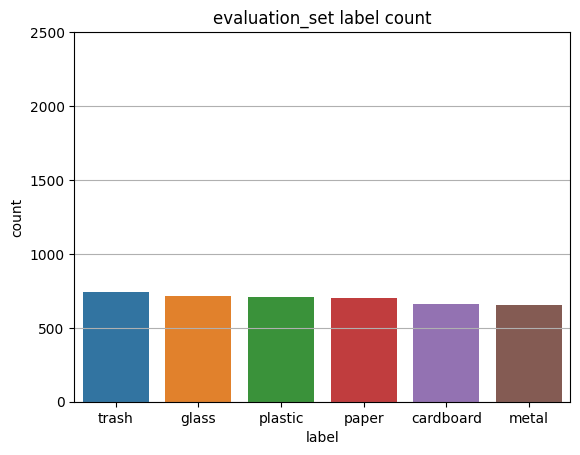

train_valid_set label
glass        1787
trash        1759
paper        1615
plastic      1583
cardboard    1556
metal        1430
Name: count, dtype: int64 


label
glass        1787
trash        1759
paper        1615
plastic      1583
cardboard    1556
metal        1430
Name: count, dtype: int64 


train label
trash        1241
glass        1215
paper        1161
plastic      1113
cardboard    1086
metal         995
Name: count, dtype: int64 


valid_set label
glass        572
trash        518
cardboard    470
plastic      470
paper        454
metal        435
Name: count, dtype: int64 




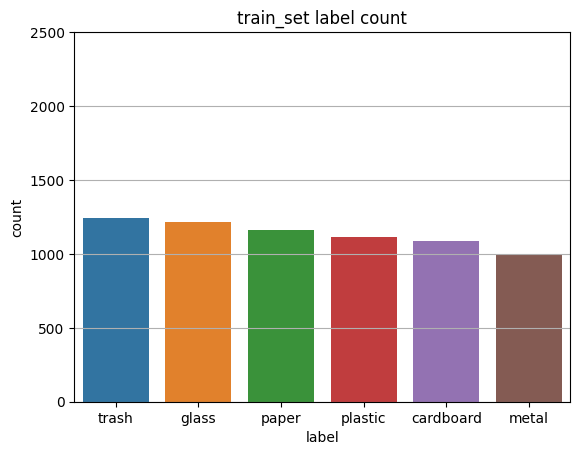

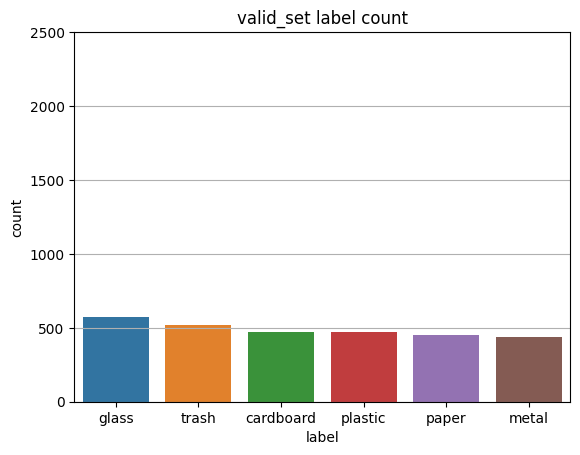

In [135]:
# Dataset to Train-valid and Eval set
# - Split en train (70%), eval (30%)
X_train_valid, X_eval, y_train_valid, y_eval = sklearn.model_selection.train_test_split(
    metadata["filename"],
    metadata["label"],
    test_size=0.3,
    random_state=42,
)
print("metadata", metadata["label"].value_counts(), '\n\n')

EVALUATION_SET = pd.concat([X_eval, y_eval], axis=1)

print("evaluation_set", EVALUATION_SET["label"].value_counts(), '\n\n')

y_lim = [0, 2500]
plot_label_distribution(
    metadata_df=EVALUATION_SET,
    label_column="label",
    title="evaluation_set label count",
    y_lim=y_lim
)

train_valid_set = pd.concat([X_train_valid, y_train_valid], axis=1)
print("train_valid_set", train_valid_set["label"].value_counts(), '\n\n')

# Dataset to Train and valid set
# - Split en train (70%), valid (30%)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    train_valid_set["filename"],
    train_valid_set["label"],
    test_size=0.3,
    random_state=42,
)

print(train_valid_set["label"].value_counts(), '\n\n')

TRAIN_SET = pd.concat([X_train, y_train], axis=1)
VALID_SET = pd.concat([X_val, y_val], axis=1)
print("train", TRAIN_SET["label"].value_counts(), '\n\n')

print("valid_set",VALID_SET["label"].value_counts(), '\n\n')

plot_label_distribution(
    metadata_df=TRAIN_SET,
    label_column="label",
    title="train_set label count",
    y_lim=y_lim
)
plot_label_distribution(
    metadata_df=VALID_SET,
    label_column="label",
    title="valid_set label count",
    y_lim=y_lim
)

In [136]:
SPLIT_DICT = {"EVALUATION_SET" : EVALUATION_SET, "TRAIN_SET":TRAIN_SET, "VALID_SET": VALID_SET}
for split_name, split_df in SPLIT_DICT.items():
    split_df.to_csv(Path(split_name).with_suffix(".csv"))
EVALUATION_SET.sample(frac=1).head()

,filename,label
13409,Garbage_Dataset_Classification/images/paper/pa...,paper
4191,Garbage_Dataset_Classification/images/plastic/...,plastic
1844,Garbage_Dataset_Classification/images/cardboar...,cardboard
6369,Garbage_Dataset_Classification/images/glass/gl...,glass
11564,Garbage_Dataset_Classification/images/trash/tr...,trash


In [140]:
# Function to convert a label into a one-hot encoded array
# label_to_index = {label: i for i, label in enumerate(CLASSES)}

label_to_index = tf.lookup.KeyValueTensorInitializer(
    keys=tf.constant(CLASSES),
    values=tf.constant(list(range(len(CLASSES))), dtype=tf.int64)
)
label_to_index = tf.lookup.StaticHashTable(label_to_index, default_value=-1)

def one_hot_encode(features: np.ndarray, label: str, num_classes=len(CLASSES)):
    label_encoded = label_to_index.lookup(label) # string to integer 
    one_hot = tf.one_hot(label_encoded, num_classes) # int to one hot vector
    return features, one_hot


def load_image(path_to_image: str, label: str):
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_jpeg(img, channels=3)  # rgb image
    img = tf.image.resize(img, [256, 256])  # 256x256 image
    img = img / 255.0  # Normalize [0,1]
    return img, label


def build_image_dataset(dataframe: pd.DataFrame):
    tf_dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["filename"], dataframe["label"])
    )
    tf_dataset = tf_dataset.map(load_image)
    tf_dataset = tf_dataset.map(one_hot_encode)
    return tf_dataset.batch(32).cache()

tf_eval_dataset = build_image_dataset(EVALUATION_SET)
tf_train_dataset = build_image_dataset(TRAIN_SET)
tf_valid_dataset = build_image_dataset(VALID_SET)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models


# Charger ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
base_model.trainable = False  # On gèle les poids pour l'instant

garbage_cnn = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='sigmoid')  # num_classes = nombre de classes de ton dataset
])

garbage_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    TensorBoard,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
import datetime

early_stop = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# tensorboard settings
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir, histogram_freq=1, update_freq="epoch"
)

In [ ]:
history_finetune = garbage_cnn.fit(
    tf_train_dataset,
    validation_data=tf_valid_dataset,
    epochs=100,
    callbacks=[tensorboard_callback, early_stop],
)

Epoch 1/10


2025-09-25 10:09:05.306994: I external/local_xla/xla/service/service.cc:163] XLA service 0x7eb3440024c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-25 10:09:05.307015: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-09-25 10:09:05.442422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-25 10:09:06.380597: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-25 10:09:07.624091: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_cal

  2/213 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.1406 - loss: 0.9796

I0000 00:00:1758787751.202703    9626 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1915 - loss: 0.5188

2025-09-25 10:09:34.993443: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[27,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-25 10:09:35.624346: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[27,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,128,32,32]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1916 - loss: 0.5186

2025-09-25 10:09:49.214164: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-25 10:09:49.550884: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,128,32,32]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

213/213 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - accuracy: 0.2107 - loss: 0.4743 - val_accuracy: 0.2785 - val_loss: 0.4380
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.2497 - loss: 0.4467 - val_accuracy: 0.2563 - val_loss: 0.4327
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.2569 - loss: 0.4437 - val_accuracy: 0.2830 - val_loss: 0.4302
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.2663 - loss: 0.4408 - val_accuracy: 0.2974 - val_loss: 0.4296
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.2762 - loss: 0.4387 - val_accuracy: 0.3056 - val_loss: 0.4268
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - accuracy: 0.2863 - loss: 0.4365 - val_accuracy: 0.3080 - val_loss: 0.4247
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.2953 - loss: 0.4336 - val_accuracy: 0.3234 - val_loss: 0.4220
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.2907 - loss: 0.4335 - val